# Imports:

In [8]:
import numpy as np
from numpy import cos
from numpy import sin
import matplotlib.pyplot as plt
import itertools
from scipy.integrate import simps
import pycbc
import pycbc.waveform
from pycbc.waveform import Array
from pycbc.detector import Detector
frequencies = np.logspace(0,6,10000)

# Antenna Pattern Calculation:

In [2]:
def antenna_Pattern(freqS, num, L):                    
    freqS = freqS
    num = num
    thetas = np.linspace(0, np.pi, num)
    phis = np.linspace(0, 2*np.pi, num+1)
    dth = np.diff(thetas)[0]
    dphi = np.diff(phis)[0]
    L=L
    
    def D(f, ne):
        c = 3e8
        arg = 2*np.pi*f*L/c
        val = np.sinc(arg /np.pi) - ne**2 * np.sinc(ne*arg /np.pi) - 1j*ne/arg *(np.cos(arg) - np.cos(ne*arg))
        val *= np.exp(-1j*arg) / 2/(1-ne**2)
        return val

    def antenna(f, th, phi):
        phi = - phi
        n_hat = np.array([np.sin(th)*np.cos(phi), np.sin(th)*np.sin(phi), np.cos(th)])
        th_hat = np.array([np.cos(th)*np.cos(phi), np.cos(th)*np.sin(phi), -np.sin(th)])
        phi_hat = np.array([-np.sin(phi), np.cos(phi), 0])
        l = th_hat
        m = phi_hat
        ex = np.array([1,0,0])
        ey = np.array([0,1,0])
        ep = np.outer(l,l) - np.outer(m,m)
        em = np.outer(l,m) + np.outer(m,l)

        Dmat = D(f,np.dot(n_hat,ex))[:,None,None] * np.outer(ex,ex) - D(f, np.dot(n_hat,ey))[:,None,None] * np.outer(ey,ey) 
        Fp = np.einsum("...jk, jk-> ...",Dmat,ep)
        Fc = np.einsum("...jk, jk-> ...",Dmat,em)

        return Fp, Fc

    def wrapper(freqS, x):
        return antenna(freqS, x[0], x[1])
    
    all = list(itertools.product(thetas, phis))
    res = np.array([wrapper(freqS, a) for a in all])

    sth = np.array([np.sin(a[0]) for a in all])
    Fp = res[:,0,:]
    Fc = res[:,1,:]

    F_ave = np.sum((np.abs(Fp)**2 + np.abs(Fc)**2) * sth[:,None],axis = 0) *dth*dphi / (4*np.pi)
    
    return np.sqrt(F_ave)

# Create and view npz file for antenna pattern for LIGO and GEO600:

In [13]:
# Calculate Antenna Pattern to use for npz file:
Fave = antenna_Pattern(Array(frequencies), 50, 1200) #inputs are frequency array, number of points to sky-average over, and search-space length of interferometer arms (4000 for LIGO, 40000 for CE)
Fave2 = antenna_Pattern(Array(frequencies), 50, 600) #inputs are frequency array, number of points to sky-average over, and search-space length of interferometer arms (4000 for LIGO, 40000 for CE)

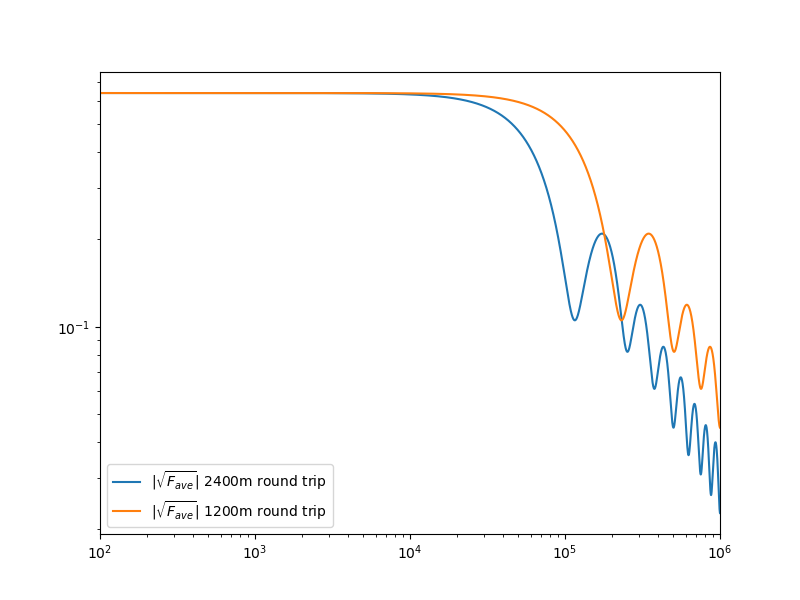

In [14]:
# Graph antenna patterns:
%matplotlib widget
plt.figure(figsize=(8,6))
plt.loglog(frequencies, Fave,label=r'$|\sqrt{F_{ave}}|$ 2400m round trip')
plt.loglog(frequencies, Fave2,label=r'$|\sqrt{F_{ave}}|$ 1200m round trip')
plt.legend()
plt.xlim(100,1e6)
plt.show()

In [5]:
# Uncomment the section that needs to be completed



# Create and initialize a npz file:

# np.savez('CE_F_rms_100000_05.npz', freqs=np.logspace(0,5,100000), F_rms = Fave1)


# Add ASD arrays of antenna patterns to the npz file:

# with np.load('Antenna_Patterns.npz') as data:
#     existing_data = dict(data.items())
#     existing_data['Fcross'] = Fc1
#     # Save the updated data back to the .npz file
#     np.savez('Antenna_Patterns.npz', **existing_data)


# To view the array names in the file:

# with np.load('LIGO Antenna_Patterns.npz') as data:
#     for name in data.files:
#         print(name)